# Install

In [1]:
%pip install tensorflow tf2onnx matplotlib numpy opencv-python scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade --force-reinstall numpy h5py tensorflow

  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached h5py-3.15.0-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached termco

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.


# import and constant

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import string
import os
import shutil

In [4]:
dataset_dir = './dataset'
model_name = 'sign_classifier'

# Dataset

In [6]:
!curl -L -o ./alfabet-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/achmadnoer/alfabet-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  114M    0 83232    0     0  54378      0  0:36:51  0:00:01  0:36:50 54378
  8  114M    8 10.0M    0     0  4148k      0  0:00:28  0:00:02  0:00:26 10.5M
 18  114M   18 21.2M    0     0  6273k      0  0:00:18  0:00:03  0:00:15 10.9M
 28  114M   28 32.5M    0     0  7453k      0  0:00:15  0:00:04  0:00:11 11.0M
 38  114M   38 43.8M    0     0  8198k      0  0:00:14  0:00:05  0:00:09 11.0M
 48  114M   48 55.1M    0     0  8716k      0  0:00:13  0:00:06  0:00:07 11.1M
 56  114M   56 65.1M    0     0  8920k      0  0:00:13  0:00:07  0:00:06 11.0M
 66  114M   66 76.4M    0     0  9230k      0  0:0

In [18]:
import zipfile
import os
import platform

zip_path = "./alfabet-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./alfabet-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [19]:
import os
import shutil

src_dir = "Citra BISINDO"
dst_dir = "./dataset"

if not os.path.exists(src_dir):
    raise FileNotFoundError(f"❌ Folder sumber tidak ditemukan: {src_dir}")

os.makedirs(dst_dir, exist_ok=True)

print(f"📂 Memindahkan '{src_dir}' ke '{dst_dir}' ...")
shutil.move(src_dir, dst_dir)
print(f"✅ Berhasil dipindahkan ke {dst_dir}")


📂 Memindahkan 'Citra BISINDO' ke './dataset' ...
✅ Berhasil dipindahkan ke ./dataset


In [1]:
!curl -L -o ./indonesian-sign-language-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/agungmrf/indonesian-sign-language-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1396M    0  110k    0     0  70686      0  5:45:23  0:00:01  5:45:22  111k
  0 1396M    0 2528k    0     0   976k      0  0:24:25  0:00:02  0:24:23 1277k
  0 1396M    0 7005k    0     0  1950k      0  0:12:13  0:00:03  0:12:10 2350k
  0 1396M    0 11.4M    0     0  2551k      0  0:09:20  0:00:04  0:09:16 2942k
  1 1396M    1 16.0M    0     0  2945k      0  0:08:05  0:00:05  0:08:00 3306k
  1 1396M    1 20.4M    0     0  3179k      0  0:07:29  0:00:06  0:07:23 4178k
  1 1396M    1 23.4M    0     0  3167k      0  0:07:31  0:00:07  0:07:24 4303k
  1 1396M    1 27.1M    0     0  3238k      0  0:0

In [2]:
def merge_dataset(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    Example: src_folder/cat -> dataset/cat
             src_folder/dog -> dataset/dog
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all label folders in the source
    for label in os.listdir(src_folder):
        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Skip if not a folder
        if not os.path.isdir(label_path_src):
            continue

        # Create label folder in destination if needed
        os.makedirs(label_path_dest, exist_ok=True)

        # Move all files from src → dest
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Avoid overwriting files with same name
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_2{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
import zipfile
import os
import platform

zip_path = "./indonesian-sign-language-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./indonesian-sign-language-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [8]:
merge_dataset('./bisindo/images/train')

✅ Merged './bisindo/images/train' into './dataset' successfully!


In [9]:
merge_dataset('./bisindo/images/val')

✅ Merged './bisindo/images/val' into './dataset' successfully!


In [10]:
import shutil
import os

folder_path = "./bisindo"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./bisindo
✅ Folder berhasil dihapus.


In [11]:
!curl -L -o ./bisindo-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/yunitayupratiwi/bisindo-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [12]:
import zipfile
import os
import platform

zip_path = "./bisindo-dataset.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-dataset.zip ...
✅ Dataset berhasil diekstrak ke ./


In [13]:
def construct_dataset(src_folder):
    """
    Move files from src_folder into dataset, based on the first letter of the filename.
    Example: src_folder/A.66ae97e2-c1e4-11eb-83d3-0008ca6b6d30.jpg -> dataset/A
             src_folder/B.002d8fdf-c1e3-11eb-952a-0008ca6b6d30.jpg -> dataset/B
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all file folders in the source
    for filename in os.listdir(src_folder):
        src_file = os.path.join(src_folder, filename)

        # Skip if a folder
        if os.path.isdir(src_file):
            continue
        
        # Skip if not a jpg
        if not src_file.lower().endswith('.jpg'):
            continue
        
        label = filename[0].upper()  # First character as label
        dest = os.path.join(dataset_dir, label)
        # Create label folder in destination if needed
        os.makedirs(dest, exist_ok=True)

        dst_file = os.path.join(dest, filename)

        # Avoid overwriting files with same name
        if os.path.exists(dst_file):
            base, ext = os.path.splitext(filename)
            dst_file = os.path.join(dest, f"{base}_3{ext}")

        shutil.move(src_file, dst_file)

    print(f"successfully!")

In [14]:
construct_dataset("./BISINDO - Dataset/test")

successfully!


In [15]:
construct_dataset("./BISINDO - Dataset/train")

successfully!


In [16]:
import shutil
import os

folder_path = "./BISINDO - Dataset"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./BISINDO - Dataset
✅ Folder berhasil dihapus.


# Train

In [17]:
# === 1. ImageDataGenerator dengan validation split ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% untuk validasi
)

In [18]:
# === 2. Generator training ===
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 12172 images belonging to 27 classes.


In [ ]:
# === 3. Generator validation ===
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

In [ ]:
# === 4. Bangun model MobileNetV2 ===
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False,
    input_shape=(224, 224, 3)
)

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# === 5. Compile model ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# === 6. Tambahkan EarlyStopping ===
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# === 7. Train model dengan validasi ===
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 109s 296ms/step - accuracy: 0.9769 - loss: 0.0710
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.9375 - loss: 0.3268   
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 108s 292ms/step - accuracy: 0.9767 - loss: 0.0709
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.9375 - loss: 0.1539   
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 104s 284ms/step - accuracy: 0.9788 - loss: 0.0604
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.9688 - loss: 0.2666   
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 107s 290ms/step - accuracy: 0.9828 - loss: 0.0525
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.9688 - loss: 0.0551   
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 103s 279ms/step - accuracy: 0.9839 - loss: 0.0568
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 1.0000 - loss: 0.0037   


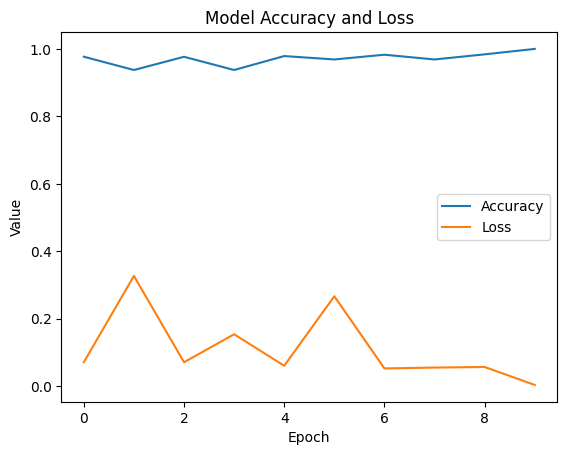

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'])
plt.show()

# save model

In [ ]:
model.save(f"{model_name}.keras")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open(f"{model_name}.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75/assets


INFO:tensorflow:Assets written to: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75/assets


Saved artifact at '/var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  6010126160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079024016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079022288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6010125776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6010125968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6010119632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079023632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079024784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079024400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079024208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6079021328: TensorS

W0000 00:00:1760521269.879621 24783483 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1760521269.879659 24783483 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-15 16:41:09.879916: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75
2025-10-15 16:41:09.888490: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-15 16:41:09.888542: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75
2025-10-15 16:41:09.977671: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-15 16:41:10.523603: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmpy5vxmh75
2025-10-15 16:41:10.641098: I tensorflow/cc/saved_model/loader.c

# test model

In [5]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=f"{model_name}.tflite")
interpreter.allocate_tensors()

/opt/anaconda3/envs/ai-rhn/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
# Get input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape'][1:3]  # (224, 224)

In [7]:
# List of labels A-Z
labels = list(string.ascii_uppercase)

In [8]:
from IPython.display import display, clear_output
import cv2
import numpy as np
from PIL import Image
import time


cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img = cv2.resize(frame, (224, 224))
        input_data = np.expand_dims(img.astype(np.float32) / 255.0, axis=0)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output)
        letter = labels[pred] if pred < len(labels) else "?"

        cv2.putText(frame, f"Pred: {letter}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        clear_output(wait=True)
        display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

finally:
    cap.release()
    time.sleep(0.5)
    del cap
    cv2.VideoCapture(0).release()
    cv2.destroyAllWindows()
    print("Camera released.")


Camera released.


KeyboardInterrupt: 